# Load Data

In [3]:
%matplotlib inline
import pandas
import numpy as np
from matplotlib import pyplot as plt

df = pandas.read_csv('d.csv', index_col=0)
df = df.filter(like='ETF', axis=0)
a = df.iloc[:, :-1]
b = df.iloc[:, 1:]
b.columns = a.columns = range(df.shape[1] - 1)
r = (b - a) / a
p = 1 / np.linalg.norm(r, axis=1)
r = (r.T * p).T.values
l = r.shape[0]
cor = np.ones([l, l])
for i in range(l):
    for j in range(i + 1, l):
        s = (r[i] * r[j]).sum()
        cor[i][j] = s
        cor[j][i] = s

base = 10
d = np.concatenate((np.ones([r.shape[0], 1]) * base,
                    np.add.accumulate(r, axis=1) + np.ones(r.shape) * base), axis=1)

# Test random output distribution

In [ ]:
import random

dist = []
n = 6
for i in range(100000):
    choice = random.sample(range(d.shape[0]), n)
    # if 372 not in choice:
    #     choice = choice + [372]
    bad = True
    while bad:
        bad = False
        for k in range(len(choice)):
            for l in range(k):
                if np.abs(cor[choice[k]][choice[l]]) > 0.75:
                    bad = True
                    break
            if bad:
                break
        if bad:
            choice = random.sample(range(d.shape[0]), n)
            # if 372 not in choice:
            #     choice = choice + [372]

    s = d[choice].sum(axis=0)
    s = s / n
    m = s.mean()
    s = s / m
    x = np.arange(len(s)) + 1
    a, b = np.polyfit(x, np.log(s), 1)
    y = np.exp(a * x + b)

    # reg times
    last = s[0] < y[0]
    reg = 0
    regDist = [0]
    for i in range(1, len(s)):
        if (s[i] < y[i]) != last:
            regDist.append(i)
            reg += 1
            last = s[i] < y[i]

    # reg distribution
    regDist = np.array(regDist)
    regStd = (regDist[1:] - regDist[:-1]).std()
    dist.append(regStd)
    
pandas.DataFrame(dist).hist(bins=1000)
pandas.qcut(dist,  [0, 0.05, 0.1, 0.25, 0.5, 0.75, 1])

# Load Weekly data and clean into d.csv

In [ ]:
%matplotlib inline
import pandas
from glob import glob
import numpy as np

df = None
for f in glob('D:\\work\\main\\IB\\*_week.csv'):
    if df is None:
        df = pandas.read_csv(f, index_col=0).T
    else:
        df = pandas.concat([df,pandas.read_csv(f, index_col=0).T], axis=1)

d = df.iloc[-112:-1,:]
d = d.dropna(axis=1,how='any').astype('float32').T
d.to_csv('d.csv')

In [ ]:
print(np.round(p[idx] / p[idx].min() * 7))
print((p[idx] / p[idx].min() * 7 * daily[got]).sum(axis=1))

# Test by day data

[16. 11. 59. 13.  2.]
1496116800000    5599.65
1496203200000    5601.04
1496289600000    5606.07
1496376000000    5628.00
1496635200000    5619.40
1496721600000    5626.18
1496808000000    5627.31
1496894400000    5648.56
1496980800000    5614.78
1497240000000    5601.51
1497326400000    5613.40
1497412800000    5603.13
1497499200000    5568.36
1497585600000    5571.79
1497844800000    5585.77
1497931200000    5557.20
1498017600000    5564.65
1498104000000    5567.39
1498190400000    5569.16
1498449600000    5573.42
1498536000000    5535.59
1498622400000    5563.86
1498708800000    5531.91
1498795200000    5514.56
1499054400000    5507.85
1499227200000    5529.70
1499313600000    5520.18
1499400000000    5521.54
1499659200000    5527.72
1499745600000    5547.10
                  ...   
1523937600000    5888.29
1524024000000    5866.36
1524110400000    5808.44
1524196800000    5783.66
1524456000000    5769.62
1524542400000    5753.33
1524628800000    5741.31
1524715200000    5773.41
152

5.910638926067594

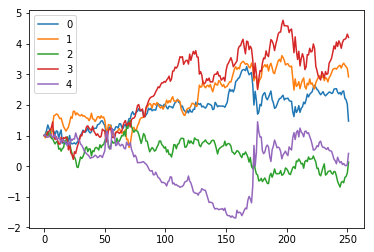

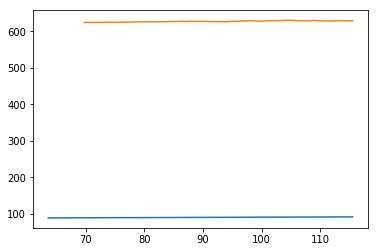

In [60]:
from glob import glob
daily = pandas.read_csv('day.csv', index_col=0)[columns].T
a = daily.iloc[:, :-1]
b = daily.iloc[:, 1:]
b.columns = a.columns = range(daily.shape[1] - 1)
percent = np.round(p[idx] / p[idx].min() * 2)
print(percent)
print((daily.T * percent).T.sum(axis=0))
r = (((b - a) / a).T * percent).T
pandas.DataFrame(np.concatenate((np.ones([r.shape[0], 1]) * 1,
                    np.add.accumulate(r, axis=1) + np.ones(r.shape) * 1), axis=1)).T.plot()

dates = daily.columns.astype(np.float32)
dates = np.round((dates - startDate) / 3600 / 24 / 1000) / 7 + 1

y = np.exp(A * dates + B) * len(columns) / p[idx].min()
y2 = r.sum(axis=0).values
y2 = np.concatenate((np.ones(1) * 625,
                    np.add.accumulate(y2) + np.ones(y2.shape[0]) * 625))
plt.figure()
plt.plot(dates, y)
plt.plot(dates[30:], y2[30:])
y2[-1] / y[-1] - 1

In [51]:
from glob import glob
%matplotlib inline
import pandas
import numpy as np
from matplotlib import pyplot as plt

daily = None
for f in glob('D:\\work\\main\\IB\\*_day.csv'):
    if daily is None:
        daily = pandas.read_csv(f, index_col=0).T
    else:
        daily = pandas.concat([daily,pandas.read_csv(f, index_col=0).T], axis=1)
daily.to_csv('day.csv')

['欧盟国家ETF-iShares MSCI', '银行指数ETF-SPDR KBW', 'Schwab U.S. TIPs ETF', '半导体指数ETF-HOLDRs', '1.5倍做多波动率指数短期期货ETF-ProShares']
[[ 1.          0.43665851  0.06877633  0.47994739 -0.63610985]
 [ 0.43665851  1.         -0.35759125  0.36710987 -0.57259817]
 [ 0.06877633 -0.35759125  1.          0.05145339 -0.08503238]
 [ 0.47994739  0.36710987  0.05145339  1.         -0.65050416]
 [-0.63610985 -0.57259817 -0.08503238 -0.65050416  1.        ]]
[1.         1.01626186 1.07162831 1.07698039 1.03380411]
(111,)
[ 4.57556245  3.12805631 17.27887782  3.68879802  0.58614536]
a,b 0.0006112699067008909 2.29700881391268
47


Float64Index([   0.004977355257064664,   -0.001244252026427084,
                 0.002834852605503979, -0.00017533161313532108,
                0.0029513290005260817,   0.0037270551988619616,
                 0.004118070649328454,   -0.003940612885940276,
                -0.005780176467036657,  -0.0037868592209144847,
              ...
                 0.002411178038760342,   0.0021121018667638047,
                0.0064629035019305725,    0.005157968710934879,
               -0.0024375586176937913,   0.0008782878335400479,
                -0.003214015971672368,   0.0005751718593032251,
                -0.004759661473438093,    -0.00570104412108996],
             dtype='float64', length=111)

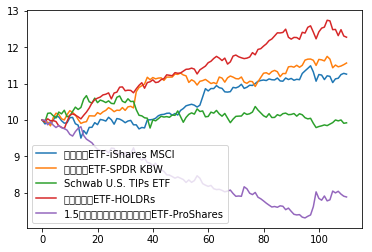

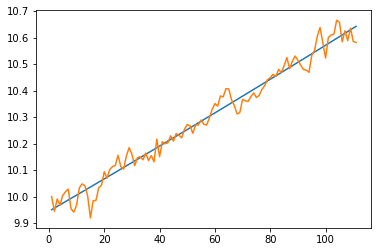

In [56]:
idx = [25, 53, 67, 73, 91]

columns = list(np.array(df.index)[idx])
print(columns)

coridx = np.ones([len(idx), len(idx)])
for i in range(len(idx)):
    for j in range(i):
        if np.abs(cor[idx[i]][idx[j]]) > 0.75:
            print('correlation too high')
        coridx[i][j] = cor[idx[i]][idx[j]]
        coridx[j][i] = cor[idx[j]][idx[i]]
print(coridx)

a = d[idx][:, 1:]
b = d[idx][:, :-1]
r = a - b
contri= np.abs(r).mean(axis=1)
contri = contri / contri.min()
print(contri)

graph = pandas.DataFrame(d[idx]).T
graph.columns = columns 
graph.plot()
d[idx].sum(axis=0)[-1]



s = (d[idx]).sum(axis=0)
print(s.shape)
print(p[idx])

dates = df.columns.astype(np.float32)
startDate = dates[0]
dates = np.round((dates - startDate) / 3600 / 24 / 1000 / 7) + 1

s = s / len(idx)
A, B = np.polyfit(dates, np.log(s), 1)
print('a,b', A, B)
y = np.exp(A * dates + B)
last = s[0] < y[0]
reg = 0
for i in range(1, len(s)):
    if (s[i] < y[i]) != last:
        reg += 1
        last = s[i] < y[i]
print(reg)

plt.figure()
plt.plot(dates, y)
plt.plot(dates, s)
s / y - 1